In [44]:
import os
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2

In [2]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 128, 128, 3
NUM_CLASSES = 3  # normal, maligno, benigno

In [3]:
def build_unet_classification(input_shape):
    inputs = Input(input_shape)

    # Contracción
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansión
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Conv2D(512, (2, 2), activation='relu', padding='same')(u6)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Conv2D(256, (2, 2), activation='relu', padding='same')(u7)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Conv2D(128, (2, 2), activation='relu', padding='same')(u8)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Conv2D(64, (2, 2), activation='relu', padding='same')(u9)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Clasificación
    f = Flatten()(c9)
    d = Dense(128, activation='relu')(f)
    d = Dropout(0.5)(d)
    outputs = Dense(NUM_CLASSES, activation='softmax')(d)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

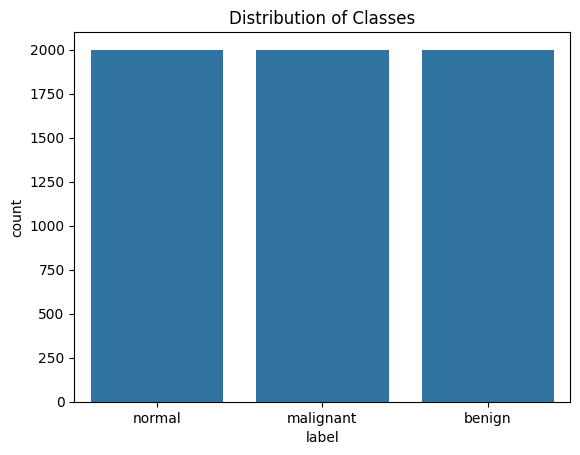

In [4]:
data_dir = './archive/CLAHE_images'
label_map = {'normal': 0, 'malignant': 1, 'benign': 2}

# Crear una nueva carpeta para el subconjunto de datos
subset_data_dir = './subset_CLAHE_images'
if os.path.exists(subset_data_dir):
    shutil.rmtree(subset_data_dir)
os.makedirs(subset_data_dir, exist_ok=True)

# Seleccionar aleatoriamente 2000 imágenes de cada clase
NUM_IMAGES_PER_CLASS = 2000
for label in label_map.keys():
    label_dir = os.path.join(data_dir, label)
    subset_label_dir = os.path.join(subset_data_dir, label)
    os.makedirs(subset_label_dir, exist_ok=True)

    images = os.listdir(label_dir)
    np.random.shuffle(images)
    selected_images = images[:NUM_IMAGES_PER_CLASS]

    for image in selected_images:
        src = os.path.join(label_dir, image)
        dst = os.path.join(subset_label_dir, image)
        shutil.copy(src, dst)

# Distribución de las clases
counts = {label: len(os.listdir(os.path.join(subset_data_dir, label))) for label in label_map.keys()}
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count']).reset_index()
df_counts.columns = ['label', 'count']

sns.barplot(x='label', y='count', data=df_counts)
plt.title('Distribution of Classes')
plt.show()


In [5]:
# Configuración del generador de datos usando el subconjunto
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    subset_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    subset_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4800 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [37]:
# Tabla de las capas y neuronas del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]  

 Total params: 495,749,771 (1.85 GB)

 Trainable params: 165,249,923 (630.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 330,499,848 (1.23 GB)

In [6]:
# Construir y compilar el modelo U-NET
model = build_unet_classification((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

# Guardar el modelo
model.save('unet_model_simplified.keras')

# Evaluar el modelo
y_val_true = validation_generator.classes
y_val_pred = model.predict(validation_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

accuracy = accuracy_score(y_val_true, y_val_pred_classes)
precision = precision_score(y_val_true, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true, y_val_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


I0000 00:00:1721840430.358621    7881 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721840430.397484    7881 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721840430.397546    7881 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721840430.404528    7881 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721840430.404642    7881 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/30


/home/daniel/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721840435.251894    8060 service.cc:146] XLA service 0x7efbf400f480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721840435.251938    8060 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-07-24 12:00:35.357442: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 12:00:35.797202: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
20

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6098 - loss: 1.2382

2024-07-24 12:01:42.527477: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-24 12:01:43.494613: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-24 12:01:44.996841: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-24 12:01:45.752678: W external/local_tsl/tsl/framework/bfc_

150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 372ms/step - accuracy: 0.6106 - loss: 1.2345 - val_accuracy: 0.7217 - val_loss: 0.4965
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.8599 - loss: 0.3283 - val_accuracy: 0.7333 - val_loss: 0.4634
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.8861 - loss: 0.2770 - val_accuracy: 0.7508 - val_loss: 0.4862
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.9057 - loss: 0.2237 - val_accuracy: 0.7600 - val_loss: 0.4629
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - accuracy: 0.9155 - loss: 0.2051 - val_accuracy: 0.7783 - val_loss: 0.4150
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 287ms/step - accuracy: 0.9352 - loss: 0.1734 - val_accuracy: 0.7842 - val_loss: 0.5018
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - accuracy: 0.9474 - loss: 0.1346 - val_accuracy: 0.8050 - val_loss: 0.5852
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 304ms/step - accuracy: 0.9544 - loss: 0.1166 - val

In [7]:
# Clasificación report
target_names = list(train_generator.class_indices.keys())
print(classification_report(y_val_true, y_val_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

      benign       0.34      0.23      0.27       400
   malignant       0.33      0.45      0.38       400
      normal       0.34      0.33      0.33       400

    accuracy                           0.34      1200
   macro avg       0.34      0.33      0.33      1200
weighted avg       0.34      0.34      0.33      1200



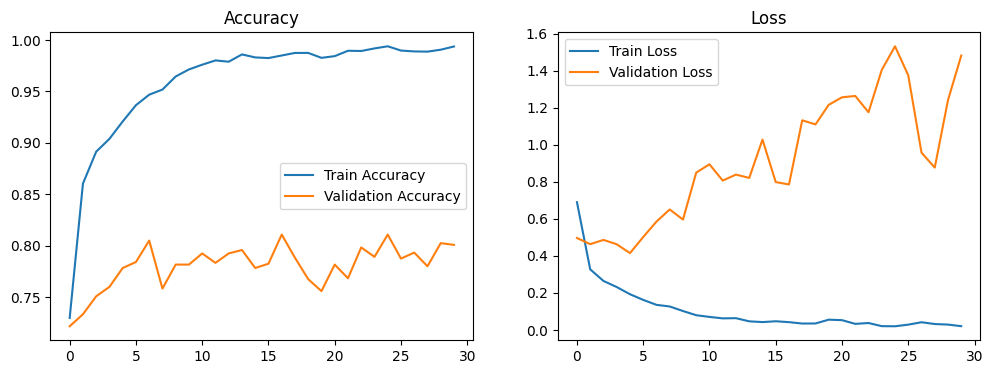

In [8]:
# Gráfico de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [42]:
def predict_image(model, image_path, img_height, img_width, label_map):
    # Cargar y preprocesar la imagen
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Realizar la predicción
    prediction = model.predict(img_array)
    
    # Obtener la clase con la mayor probabilidad
    predicted_class = np.argmax(prediction[0])
    predicted_label = label_map[predicted_class]
    confidence = prediction[0][predicted_class]
    
    # Mostrar confianza para cada categoría
    confidences = {label_map[i]: f"{prediction[0][i] * 100:.2f}%" for i in range(len(prediction[0]))}
    
    return predicted_label, confidence, confidences

In [45]:
# Ruta de la nueva imagen
new_image_path = './archive/CLAHE_images/normal/normal345.png'
label_map_reverse = {v: k for k, v in train_generator.class_indices.items()}

predicted_label, confidence, confidences = predict_image(model, new_image_path, IMG_HEIGHT, IMG_WIDTH, label_map_reverse)
print(f"Predicted Label: {predicted_label}, Confidence: {confidence:.4f}")
print("Confidences:")
for label, conf in confidences.items():
    print(f"{label}: {conf}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted Label: normal, Confidence: 1.0000
Confidences:
benign: 0.00%
malignant: 0.00%
normal: 100.00%
